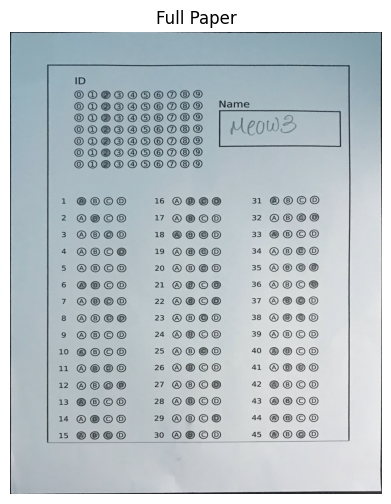

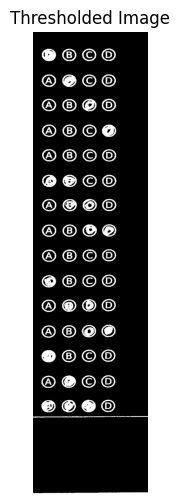

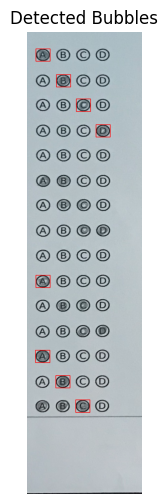

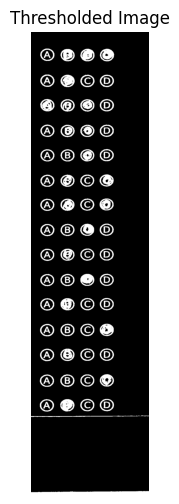

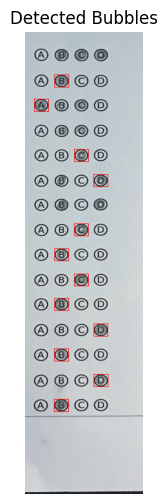

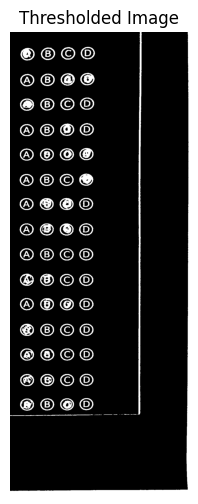

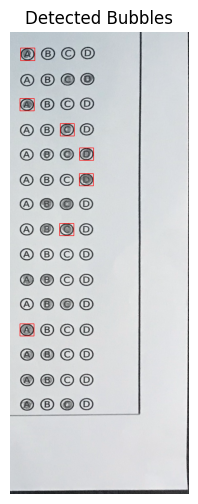

Detected Answers: ['A', 'B', 'C', 'D', 'Z', 'X', 'X', 'X', 'Z', 'A', 'X', 'X', 'A', 'B', 'C', 'X', 'B', 'A', 'X', 'C', 'D', 'X', 'C', 'B', 'C', 'B', 'D', 'B', 'D', 'B', 'A', 'X', 'A', 'C', 'D', 'D', 'X', 'C', 'Z', 'X', 'X', 'A', 'X', 'X', 'X']


In [238]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import imutils
from paperExtraction import *  # Make sure your extractPaper function is here

# ----------------------------
# Helper function
# ----------------------------
def show_image(img, title=""):
    plt.figure(figsize=(8,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# ----------------------------
# Adaptive bubble detection for ONE column
# ----------------------------
def detect_answers_column_adaptive(
        column_image,
        max_choices=None,
        min_size=10,
        aspect_ratio_tol=0.2,
        min_fill_ratio=0.6,   # 🔹 lower threshold
        row_gap_multiplier=3.0,
        multiple_tol=0.05):    # 🔹 5% tolerance for multiple selection

    gray = cv2.cvtColor(column_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)


    show_image(thresh, "Thresholded Image")

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    bubbleCnts = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        ar = w / float(h)
        if w >= min_size and h >= min_size and abs(ar - 1) <= aspect_ratio_tol:
            bubbleCnts.append(c)
    if not bubbleCnts:
        return []

    bubbleCnts = contours.sort_contours(bubbleCnts, method="top-to-bottom")[0]

    # -------- split into rows --------
    rows = []
    current_row = []
    tolerance = 10
    for c in bubbleCnts:
        x, y, w, h = cv2.boundingRect(c)
        if not current_row:
            current_row = [c]
            last_y = y
        elif abs(y - last_y) <= tolerance:
            current_row.append(c)
        else:
            rows.append(sorted(current_row, key=lambda b: cv2.boundingRect(b)[0]))
            current_row = [c]
            last_y = y
    if current_row:
        rows.append(sorted(current_row, key=lambda b: cv2.boundingRect(b)[0]))

    letters = ['A','B','C','D','E','F','G','H']
    answers = []
    filled_img = column_image.copy()
    prev_y = None
    row_heights = []

    for row in rows:
        ys = [cv2.boundingRect(c)[1] for c in row]
        hs = [cv2.boundingRect(c)[3] for c in row]
        row_y = int(np.mean(ys))
        row_h = int(np.mean(hs))
        row_heights.append(row_h)
        avg_h = np.mean(row_heights)
        if prev_y is not None and (row_y - prev_y) > row_gap_multiplier * avg_h:
            break
        prev_y = row_y
        choices = row[:max_choices] if max_choices else row

        fill_ratios = []
        for c in choices:
            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            filled_pixels = cv2.countNonZero(cv2.bitwise_and(thresh, thresh, mask=mask))
            bubble_area = cv2.countNonZero(mask)
            fill_ratios.append(filled_pixels / float(bubble_area))

        max_fill = max(fill_ratios)
        filled_indices = [i for i, r in enumerate(fill_ratios) if (max_fill - r)/max_fill <= multiple_tol and max_fill >= min_fill_ratio]

        if len(filled_indices) == 0:
            answers.append("Z")  # empty
        elif len(filled_indices) > 1:
            answers.append("X")  # multiple
        else:
            idx = filled_indices[0]
            answers.append(letters[idx])
            x, y, w, h = cv2.boundingRect(choices[idx])
            cv2.rectangle(filled_img, (x, y), (x+w, y+h), (0,0,255), 2)

    show_image(filled_img, "Detected Bubbles")
    return answers

# ----------------------------
# EXAMPLE USAGE FOR 3 COLUMNS
# ----------------------------
imagePath = "../data/images/36.jpg"
paper = extractPaper(imagePath)

h, w, _ = paper.shape
question_image = paper[h//3:, :, :]

column1 = question_image[:, int(0.164*w):int(0.37*w), :]
column2 = question_image[:, int(0.42*w):int(0.63*w), :]
column3 = question_image[:, int(0.68*w):w, :]

show_image(paper, "Full Paper")

answers_col1 = detect_answers_column_adaptive(column1)
answers_col2 = detect_answers_column_adaptive(column2)
answers_col3 = detect_answers_column_adaptive(column3)

all_answers = answers_col1 + answers_col2 + answers_col3
print("Detected Answers:", all_answers)
